## Bitcoin Momentum Analysis

In [21]:
# Import Libraries
import pandas as pd
import numpy as np
import urllib
import requests
import riskfolio as rp
from datetime import datetime, timedelta
from copy import deepcopy

from highcharts import Highchart
from chart_builder import plot_chart, CHART_DEFAULTS
from IPython.display import display, HTML, display_html
import import_ipynb

# Chart libraries + settings
# plt.style.use('seaborn-whitegrid')
pd.options.mode.chained_assignment = None  # default='warn' - disable some pandas warnings
pd.options.display.float_format = '{:,.2f}'.format


In [70]:
# MatPlotLib settings
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler
# Swan Colors
swan_colors = ['#31597F', '#7B96B0', '#C3D9E9', '#DAE1E8']
mpl.rcParams['lines.color'] = '#31597F'
mpl.rcParams['text.color'] = '#31597F'
mpl.rcParams['axes.prop_cycle'] = cycler(color=swan_colors)
mpl.rcParams['lines.linewidth'] = 1
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
sns.color_palette('pastel')
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=8)   
plt.rc('xtick', labelsize=8, color='#00305E')  
plt.rc('ytick', labelsize=8, color='#00305E')    
plt.rc('legend', fontsize=12)
plt.rc('font', size=8)          
plt.figure(figsize=(10, 4), tight_layout=True)

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [97]:
# Load Bitcoin Prices into a dataframe
# Ticker is customizable
ticker = "SPY"
# Cryptocompare URL and fiels
base_url = 'https://min-api.cryptocompare.com/data/histoday'
ticker_field = 'fsym'
field_dict = {'tsym': 'USD','allData': 'true'}
# Convert the field dict into a url encoded string
url_args = "&" + urllib.parse.urlencode(field_dict)
ticker = ticker.upper()
globalURL = (base_url + "?" + ticker_field + "=" + ticker + url_args)

In [98]:
# Request the data
resp = requests.get(url=globalURL)
data = resp.json()
data["Response"]

'Error'

In [99]:
data

{'Response': 'Error',
 'Message': 'tsym is a required param.',
 'HasWarning': False,
 'Type': 2,
 'RateLimit': {},
 'Data': {},
 'ParamWithError': 'tsym'}

In [89]:
# Parse the JSON into a Pandas DataFrame
try:
    df = pd.DataFrame.from_dict(data['Data'])
    df = df.rename(columns={'time': 'date'})
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df.set_index('date', inplace=True)
    df_save = df[['close', 'open', 'high', 'low']]
except Exception as e:
    print(e)
    df_save = None

'date'


In [90]:
# Include percentage change 
df = df_save
df['change'] = df['close'].pct_change()

TypeError: 'NoneType' object is not subscriptable

In [91]:
# To create a momentum indicator that shows if Bitcoin prices are 
# going up, down or sideways during a given time period, 
# we can calculate the rate of change (ROC) of the closing price.

x = 0.20

# Define a function to categorize momentum
def categorize_momentum(roc):
    if roc > x:
        return 'Up'
    elif roc < -x:
        return 'Down'
    else:
        return 'Sideways'

# Calculate the ROC and momentum categories
n = 30

df['ROC'] = df['close'].pct_change(n)
df['Momentum'] = df['ROC'].apply(categorize_momentum)

# Filter the DataFrame to start on January 1st, 2017
start_date = pd.to_datetime('2017-01-01')
df = df.loc[start_date:]

# Create a dictionary to map momentum categories to colors
colors = {'Up': ['green', 'green'], 'Sideways': ['yellow', 'gray'], 'Down': ['red', 'red']}

# Create the column chart
fig, ax = plt.subplots(figsize=(12, 8))
for i in df.index:
    ax.bar(i, df.loc[i, 'ROC'], width=1, color=colors[df.loc[i, 'Momentum']][0], edgecolor=colors[df.loc[i, 'Momentum']][1])

# Set the title and axis labels
ax.set_title(f"Bitcoin ROC (n={n}, x={x})")
ax.set_xlabel('Date')
ax.set_ylabel('ROC')

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add horizontal lines for reference
ax.axhline(y=-x, color='blue', linestyle='--')
ax.axhline(y=x, color='blue', linestyle='--')

# Set the chart background color to white
ax.set_facecolor('white')

# Show the chart
plt.show()


TypeError: 'NoneType' object is not subscriptable

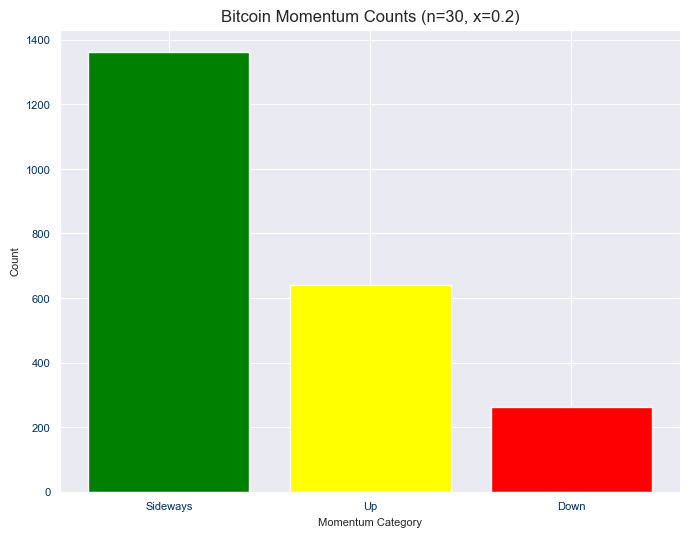

In [85]:
# Count the number of occurrences for each momentum category
counts = df['Momentum'].value_counts()

# Create a bar chart of the counts
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(counts.index, counts.values, color=['green', 'yellow', 'red'])

# Set the title and axis labels
ax.set_title(f"Bitcoin Momentum Counts (n={n}, x={x})")
ax.set_xlabel('Momentum Category')
ax.set_ylabel('Count')

# Show the chart
plt.show()

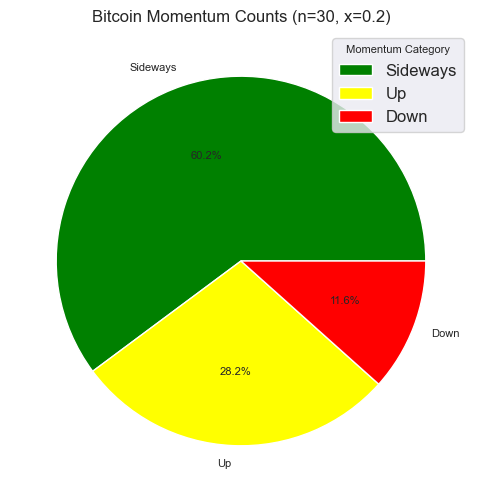

In [86]:
# Create a pie chart of the counts
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(counts.values, labels=counts.index, colors=['green', 'yellow', 'red'], autopct='%1.1f%%')

# Set the title and legend
ax.set_title(f"Bitcoin Momentum Counts (n={n}, x={x})")
ax.legend(title='Momentum Category', loc='best')

# Show the chart
plt.show()

In [79]:
from matplotlib.colors import ListedColormap

df.reset_index("date", inplace=True)
df['timestamp'] = pd.to_datetime(df['date'], unit='s')


# create heatmap of monthly returns
df_monthly = df.resample('M').last()
cmap = ListedColormap(['red', 'yellow', 'green'])
df_monthly['returns'] = df_monthly['close'].pct_change()
df_monthly['color'] = pd.cut(df_monthly['returns'], bins=[-np.inf, -0.15, 0.15, np.inf], labels=['red', 'yellow', 'green'])

# plot heatmap
sns.set_style("white")
plt.figure(figsize=(10,7))
sns.heatmap(df_monthly.pivot_table(index=df_monthly.index.year, columns=df_monthly.index.month, values='returns').fillna(0).mul(100), cmap=cmap, annot=True, fmt=".2%", cbar=False, vmin=-0.15, vmax=0.15, center=0, linewidths=.5, linecolor='gray', square=True, mask=df_monthly.pivot_table(index=df_monthly.index.year, columns=df_monthly.index.month, values='returns').isnull(), annot_kws={"size": 10})
plt.title("Bitcoin Monthly Returns Heatmap (Color: % Change from Previous Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [78]:
df

,close,open,high,low,change
date,,,,,
2010-07-17,0.05,0.05,0.05,0.05,NaN
2010-07-18,0.09,0.05,0.09,0.06,0.73
2010-07-19,0.08,0.09,0.09,0.08,-0.06
2010-07-20,0.07,0.08,0.08,0.07,-0.07
2010-07-21,0.08,0.07,0.08,0.07,0.06
...,...,...,...,...,...
2023-03-11,"20,610.50","20,207.71","20,847.54","19,898.92",0.02
2023-03-12,"22,180.75","20,610.50","22,215.00","20,448.60",0.08
2023-03-13,"24,205.82","22,180.75","24,575.29","21,897.79",0.09


In [105]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol
tickerSymbol = '^GSPC'

# Define the start and end date
start_date = '2017-01-01'
end_date = '2023-03-15'

# Download data from Yahoo Finance
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(start=start_date, end=end_date)

# Select the 'Close' column
close = tickerDf['Close']

# Create a pandas dataframe with 'Close' column
sp500_df = pd.DataFrame(close)



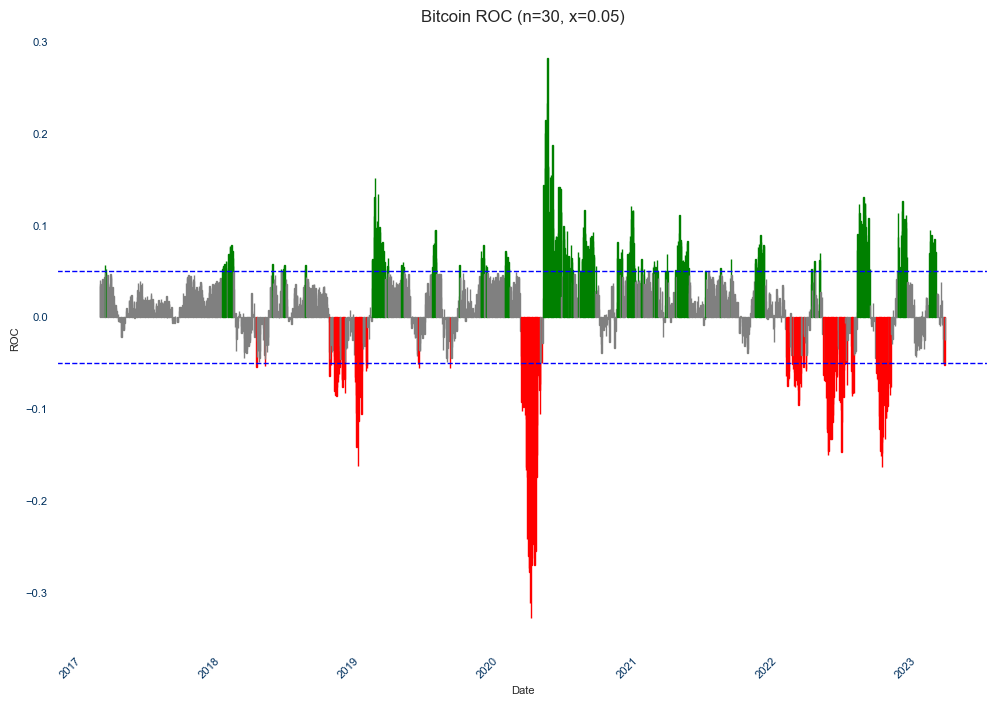

In [111]:
# To create a momentum indicator that shows if Bitcoin prices are 
# going up, down or sideways during a given time period, 
# we can calculate the rate of change (ROC) of the closing price.

x = 0.05

# Define a function to categorize momentum
def categorize_momentum(roc):
    if roc > x:
        return 'Up'
    elif roc < -x:
        return 'Down'
    else:
        return 'Sideways'

# Calculate the ROC and momentum categories
n = 30

sp500_df['ROC'] = sp500_df['Close'].pct_change(n)
sp500_df['Momentum'] = sp500_df['ROC'].apply(categorize_momentum)

# Create a dictionary to map momentum categories to colors
colors = {'Up': ['green', 'green'], 'Sideways': ['yellow', 'gray'], 'Down': ['red', 'red']}

# Create the column chart
fig, ax = plt.subplots(figsize=(12, 8))
for i in sp500_df.index:
    ax.bar(i, sp500_df.loc[i, 'ROC'], width=1, color=colors[sp500_df.loc[i, 'Momentum']][0], edgecolor=colors[sp500_df.loc[i, 'Momentum']][1])

# Set the title and axis labels
ax.set_title(f"Bitcoin ROC (n={n}, x={x})")
ax.set_xlabel('Date')
ax.set_ylabel('ROC')

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add horizontal lines for reference
ax.axhline(y=-x, color='blue', linestyle='--')
ax.axhline(y=x, color='blue', linestyle='--')

# Set the chart background color to white
ax.set_facecolor('white')

# Show the chart
plt.show()


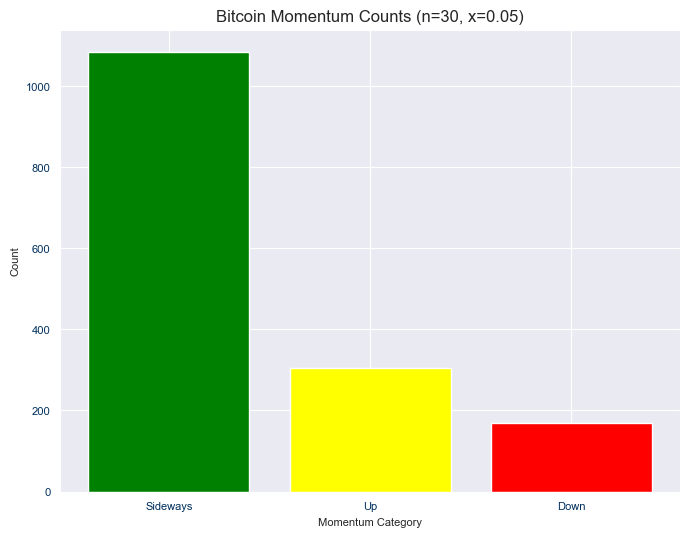

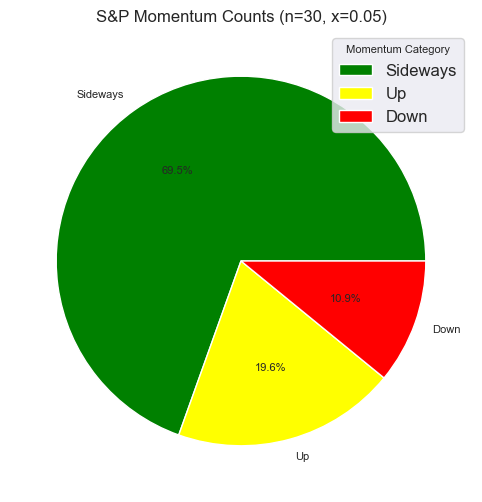

In [112]:
# Count the number of occurrences for each momentum category
counts = sp500_df['Momentum'].value_counts()

# Create a bar chart of the counts
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(counts.index, counts.values, color=['green', 'yellow', 'red'])

# Set the title and axis labels
ax.set_title(f"Bitcoin Momentum Counts (n={n}, x={x})")
ax.set_xlabel('Momentum Category')
ax.set_ylabel('Count')

# Show the chart
plt.show()
# Create a pie chart of the counts
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(counts.values, labels=counts.index, colors=['green', 'yellow', 'red'], autopct='%1.1f%%')

# Set the title and legend
ax.set_title(f"S&P Momentum Counts (n={n}, x={x})")
ax.legend(title='Momentum Category', loc='best')

# Show the chart
plt.show()